# __Training and tuning the neural network__
- Dataset: Guarujá Municipality - São Paulo - Brazil
- Part 2/3

## Authorship:
        Caio Azevedo
        São Paulo University, February, 2024

## Main goals:

- Data processing for neural network application:
   - Elimination of extraneous features.
   - Normalization of the dataset.
   - ANN training, testing and validation dataset split.

- Training and evaluation of neural networks:
   - Custom neural network implementation.
   - Keras neural network implementation.
   
- Automation of hyperparameter setup for improved performance (criterion: accuracy).
   - Brute force for optimizing hyperparameters in the custom network.
   - Keras Tuning for optimizing Keras hyperparameters.
   
- Neural network performance assessment with and without 'less important features'.

- Compare custom ANN with Keras framework

## Coding

### Imported libraries

In [1]:
import datetime
start = datetime.datetime.now()

In [2]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

### Auxiliary functions

In [6]:
# Compute and display performance metrics 
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [7]:
# Compute and print ROC curve
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('AUC ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_real))]
    p_fpr, p_tpr, _ = roc_curve(y_real, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='random', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ANN', color='blue')
    
    # axis labels
    pyplot.xlabel('false positive rate')
    pyplot.ylabel('true positive rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [8]:
# split data into training, validation and testing sets
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

In [9]:
# Plot a bubble chart with two features according to NN classification
def bubble_chart(data, col_2_buble_size, col_x, col_y):
    fig, ax = plt.subplots(figsize=(15,13))
    sizes = data[col_2_buble_size]*10
    scatter = ax.scatter(data[col_x], data[col_y], 
           c=(data['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    ax.title.set_text("{}{}".format(len(data.index), ' landslides samples')) 

    plt.show()

In [10]:
# Plot a bubble chart with two features according to NN classification and the actual values
def  bubble_double_chart(data, col_2_buble_size, col_x, col_y, accuracy):
    sizes = data[col_2_buble_size]*10

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

    scatter = axes[0].scatter(data[col_x], data[col_y],
            c=(data['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    scatter = axes[1].scatter(data[col_x], data[col_y],
            c=(data['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    fig.tight_layout()
    text = 'predicted landslides ' + 'accuracy : {:.2f}%'.format(accuracy)
    axes[0].title.set_text('actual landslides')
    axes[1].title.set_text(text)

    plt.show()

In [11]:
def out_file_name(input_file_name):
    folder_bestANN = 'bestANN\\'
    
    if not os.path.exists(folder_bestANN):
      os.mkdir(folder_bestANN)
    
    out_f = os.path.splitext(input_file_name)[0]
    
    out_NN_custom = folder_bestANN + 'customNN_' + out_f + '.pkl'
    out_NN_keras  = folder_bestANN + 'kerasNN_' + out_f
    
    return out_NN_custom, out_NN_keras

### Select the dataset

- Switch one among the nine samples used in this study. The samples are configured according to the landslides' non-occurrence points' distance from the respective occurrence spot.

In [12]:
APP_PATH = os.getcwd()
#file = "guaruja_radius_50m_shuffled.csv"
#file = "guaruja_radius_100m_shuffled.csv"
#file = "guaruja_radius_150m_shuffled.csv"
#file = "guaruja_radius_200m_shuffled.csv"

#file = "guaruja_buffer_1km_shuffled.csv"
#file = "guaruja_buffer_2km_shuffled.csv"
#file = "guaruja_buffer_3km_shuffled.csv"
#file = "guaruja_buffer_4km_shuffled.csv"

file = "guaruja_random.csv"

dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 
#dataset = dataset.sample(frac=1)
# load the dataset
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0


In [13]:
dataset.shape

(200, 11)

In [14]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.0
mean,100.50,375351.60,7350229.58,14.42,0.03,23.94,64.32,209.79,32.56,75.80,0.5
std,57.88,4313.00,4368.70,13.62,0.41,11.79,56.08,103.92,31.56,26.72,0.5
min,1.00,365857.79,7341789.72,0.09,-0.59,0.09,0.23,0.04,2.00,20.00,0.0
25%,50.75,372179.26,7346972.48,4.29,-0.01,18.08,14.33,121.04,2.00,90.00,0.0
50%,100.50,375219.03,7349677.08,6.13,-0.00,25.33,54.48,202.74,2.00,90.00,0.0
75%,150.25,379116.73,7354032.25,26.33,0.00,30.77,94.71,316.40,65.00,90.00,1.0
max,200.00,383738.84,7359892.24,69.73,4.30,69.73,226.06,359.51,65.00,90.00,1.0


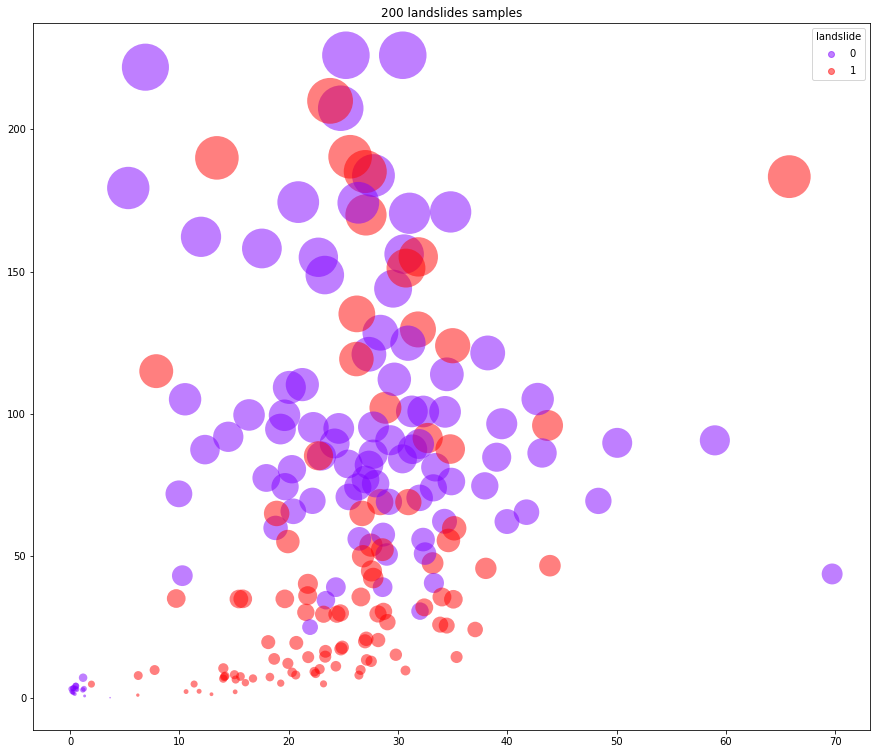

In [15]:
bubble_chart(dataset,"elevation","slope","elevation")

### Data Preparation
 - Based on the results of the feature importance analysis, all features were retained for training the ANN.
 - We addressed concerns about data leakage.

 - About most important features in best performed samples

  - Considering the random and 200m samples those with the best performance.
  - According to previous analyses we notice some features are less relevant than others.

     - In the scenario of a random sample, the pivotal features are identified as **twi**, **elevation**, and **land_use**. The overall accuracy, achieved with the optimal configuration using only these features, stands at approximately 98.50%, while utilizing all features yields a consistent 99% accuracy.

     - In instances where an event does not occur within a 200-meter radius of the sample occurrence, the most crucial features include **slope**, **twi**, **aspect**, and **curvature**. The overall accuracy, achieved with the best configuration using these features, is approximately 94.92%, compared to 93.91% when utilizing all features, a result that remains consistent.

After conducting numerous tests, it has been observed that the accuracy of the Artificial Neural Network (ANN) remains largely consistent, whether the most crucial features are included or not. Consequently, the decision has been made to retain all features in the model.

In [16]:
dataset = dataset[['slope','aspect','elevation','land_use','lithology','twi','curvature','class']]

#dataset = dataset.drop('slope',axis=1)
#dataset = dataset.drop('aspect',axis=1)

#dataset = dataset.drop('lithology',axis=1)
#dataset = dataset.drop('curvature',axis=1)

#dataset = dataset.drop('elevation',axis=1)
#dataset = dataset.drop('land_use',axis=1)

#dataset.head(5)

In [17]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation(dataset)

In [18]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [19]:
print(X_train.min(axis=0), X_test.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [ 1.63025317  0.948116    1.03804377  1.          1.          1.35762042
 -0.98499636]


In [20]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))

In [21]:
X.shape

(200, 7)

In [22]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))

In [23]:
y.shape

(200, 1)

In [24]:
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


__Compute the number of input and output features__

In [25]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

### Custom neural network training

#### Hyperparameters tunning
- Brute force method
- Custom implementation for classes and functions

In [26]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [27]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [28]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.1, patience=50) 

    #input layer
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

    #output layer
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  

    return nn

In [29]:
# (batch_size) Implements the mini-batch that accelerates the training time, requires a mini-batch initialization method. 
#It is ideal for the batch size to be a multiple of the training dataset size, which is 128 here.
neurons = [7,8,12] 
hidden_layers = [1,2,3]
learning_rate = [0.001,0.005,0.01]
batch_size = [0,4,8] 
dropout_rate = [0,0.1]
best_of_best_ANN = []
best_of_best_hyper = []

In [30]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=40000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)
                
                    y_pred = nn.predict(X_val)
                    accu = 100*accuracy_score(y_val, y_pred > 0.5)
                    #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
                    lst_hyperP.append(hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('To {} neurons, {} layer(s),  {} learning rate, {} batch size, {} dropout rate, we have: \033[1m Accuracy: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

epoch:    0/40000 loss_train: 0.78737768 + 0.00000000 = 0.78737768 loss_val = 0.78737768
epoch: 3000/40000 loss_train: 0.62343431 + 0.00000000 = 0.62343431 loss_val = 0.62343431
epoch: 6000/40000 loss_train: 0.49427490 + 0.00000000 = 0.49427490 loss_val = 0.49427490
epoch: 9000/40000 loss_train: 0.35510749 + 0.00000000 = 0.35510749 loss_val = 0.35510749
epoch: 12000/40000 loss_train: 0.27084332 + 0.00000000 = 0.27084332 loss_val = 0.27084332
epoch: 15000/40000 loss_train: 0.21062832 + 0.00000000 = 0.21062832 loss_val = 0.21062832
epoch: 18000/40000 loss_train: 0.16579490 + 0.00000000 = 0.16579490 loss_val = 0.16579490
epoch: 21000/40000 loss_train: 0.13649767 + 0.00000000 = 0.13649767 loss_val = 0.13649767
epoch: 24000/40000 loss_train: 0.11712570 + 0.00000000 = 0.11712570 loss_val = 0.11712570
epoch: 27000/40000 loss_train: 0.10356829 + 0.00000000 = 0.10356829 loss_val = 0.10356829
epoch: 30000/40000 loss_train: 0.09390352 + 0.00000000 = 0.09390352 loss_val = 0.09390352
epoch: 33000/4

epoch: 3000/40000 loss_train: 0.14292392 + 0.00000000 = 0.14292392 loss_val = 0.14292392
epoch: 6000/40000 loss_train: 0.09288113 + 0.00000000 = 0.09288113 loss_val = 0.09288113
epoch: 9000/40000 loss_train: 0.07822303 + 0.00000000 = 0.07822303 loss_val = 0.07822303
epoch: 12000/40000 loss_train: 0.07048946 + 0.00000000 = 0.07048946 loss_val = 0.07048946
epoch: 15000/40000 loss_train: 0.06574662 + 0.00000000 = 0.06574662 loss_val = 0.06574662
epoch: 18000/40000 loss_train: 0.06273422 + 0.00000000 = 0.06273422 loss_val = 0.06273422
epoch: 21000/40000 loss_train: 0.06074721 + 0.00000000 = 0.06074721 loss_val = 0.06074721
epoch: 24000/40000 loss_train: 0.05936265 + 0.00000000 = 0.05936265 loss_val = 0.05936265
epoch: 27000/40000 loss_train: 0.05832032 + 0.00000000 = 0.05832032 loss_val = 0.05832032
epoch: 30000/40000 loss_train: 0.05747211 + 0.00000000 = 0.05747211 loss_val = 0.05747211
epoch: 33000/40000 loss_train: 0.05673301 + 0.00000000 = 0.05673301 loss_val = 0.05673301
epoch: 36000/

epoch: 15000/40000 loss_train: 0.03219636 + 0.00000000 = 0.03219636 loss_val = 0.03219636
epoch: 18000/40000 loss_train: 0.02414963 + 0.00000000 = 0.02414963 loss_val = 0.02414963
epoch: 21000/40000 loss_train: 0.01861572 + 0.00000000 = 0.01861572 loss_val = 0.01861572
To 7 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.82848594 + 0.00000000 = 0.82848594 loss_val = 0.82848594
epoch: 3000/40000 loss_train: 0.05937724 + 0.00000000 = 0.05937724 loss_val = 0.05937724
epoch: 6000/40000 loss_train: 0.03621135 + 0.00000000 = 0.03621135 loss_val = 0.03621135
epoch: 9000/40000 loss_train: 0.02777567 + 0.00000000 = 0.02777567 loss_val = 0.02777567
epoch: 12000/40000 loss_train: 0.02271386 + 0.00000000 = 0.02271386 loss_val = 0.02271386
epoch: 15000/40000 loss_train: 0.01893342 + 0.00000000 = 0.01893342 loss_val = 0.01893342
epoch: 18000/40000 loss_train: 0.01589052 + 0.00000000 = 0.01589052 loss_val = 0.015890

epoch: 36000/40000 loss_train: 0.05118849 + 0.00000000 = 0.05118849 loss_val = 0.05118849
epoch: 39000/40000 loss_train: 0.04805342 + 0.00000000 = 0.04805342 loss_val = 0.04805342
To 8 neurons, 1 layer(s),  0.001 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.83187878 + 0.00000000 = 0.83187878 loss_val = 0.83187878
epoch: 3000/40000 loss_train: 0.66731077 + 0.00000000 = 0.66731077 loss_val = 0.66731077
epoch: 6000/40000 loss_train: 0.53562742 + 0.00000000 = 0.53562742 loss_val = 0.53562742
epoch: 9000/40000 loss_train: 0.35901701 + 0.00000000 = 0.35901701 loss_val = 0.35901701
epoch: 12000/40000 loss_train: 0.25545834 + 0.00000000 = 0.25545834 loss_val = 0.25545834
epoch: 15000/40000 loss_train: 0.17495603 + 0.00000000 = 0.17495603 loss_val = 0.17495603
epoch: 18000/40000 loss_train: 0.13552562 + 0.00000000 = 0.13552562 loss_val = 0.13552562
epoch: 21000/40000 loss_train: 0.11600707 + 0.00000000 = 0.11600707 loss_val = 0.116007

epoch: 3000/40000 loss_train: 0.12186388 + 0.00000000 = 0.12186388 loss_val = 0.12186388
epoch: 6000/40000 loss_train: 0.08753603 + 0.00000000 = 0.08753603 loss_val = 0.08753603
epoch: 9000/40000 loss_train: 0.07598666 + 0.00000000 = 0.07598666 loss_val = 0.07598666
epoch: 12000/40000 loss_train: 0.06895686 + 0.00000000 = 0.06895686 loss_val = 0.06895686
epoch: 15000/40000 loss_train: 0.06458119 + 0.00000000 = 0.06458119 loss_val = 0.06458119
epoch: 18000/40000 loss_train: 0.06189023 + 0.00000000 = 0.06189023 loss_val = 0.06189023
epoch: 21000/40000 loss_train: 0.06020759 + 0.00000000 = 0.06020759 loss_val = 0.06020759
epoch: 24000/40000 loss_train: 0.05905227 + 0.00000000 = 0.05905227 loss_val = 0.05905227
epoch: 27000/40000 loss_train: 0.05816002 + 0.00000000 = 0.05816002 loss_val = 0.05816002
epoch: 30000/40000 loss_train: 0.05740392 + 0.00000000 = 0.05740392 loss_val = 0.05740392
epoch: 33000/40000 loss_train: 0.05672618 + 0.00000000 = 0.05672618 loss_val = 0.05672618
epoch: 36000/

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 1 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.97095555 + 0.00000000 = 0.97095555 loss_val = 0.97095555
epoch: 3000/40000 loss_train: 0.05725364 + 0.00000000 = 0.05725364 loss_val = 0.05725364
epoch: 6000/40000 loss_train: 0.03060405 + 0.00000000 = 0.03060405 loss_val = 0.03060405
epoch: 9000/40000 loss_train: 0.02078420 + 0.00000000 = 0.02078420 loss_val = 0.02078420
epoch: 12000/40000 loss_train: 0.01489786 + 0.00000000 = 0.01489786 loss_val = 0.01489786
epoch: 15000/40000 loss_train: 0.01047883 + 0.00000000 = 0.01047883 loss_val = 0.01047883
epoch: 18000/40000 loss_train: 0.00766434 + 0.00000000 = 0.00766434 loss_val = 0.00766434
epoch: 21000/40000 loss_train: 0.00579550 + 0.00000000 = 0.00579550 loss_val = 0.00579550
epoch: 24000/40000 loss_train: 0.00451968 + 0.00000000 = 0.00451968 loss_val = 0.00451968
epoch: 27000/40000 loss_train: 0.00362223 + 0.00000000 = 0.00362223 loss_val = 0.003622

epoch: 18000/40000 loss_train: 0.08460176 + 0.00000000 = 0.08460176 loss_val = 0.08460176
epoch: 21000/40000 loss_train: 0.07622234 + 0.00000000 = 0.07622234 loss_val = 0.07622234
epoch: 24000/40000 loss_train: 0.06988618 + 0.00000000 = 0.06988618 loss_val = 0.06988618
epoch: 27000/40000 loss_train: 0.06478012 + 0.00000000 = 0.06478012 loss_val = 0.06478012
epoch: 30000/40000 loss_train: 0.06046510 + 0.00000000 = 0.06046510 loss_val = 0.06046510
epoch: 33000/40000 loss_train: 0.05679283 + 0.00000000 = 0.05679283 loss_val = 0.05679283
epoch: 36000/40000 loss_train: 0.05362314 + 0.00000000 = 0.05362314 loss_val = 0.05362314
epoch: 39000/40000 loss_train: 0.05085751 + 0.00000000 = 0.05085751 loss_val = 0.05085751
To 12 neurons, 1 layer(s),  0.001 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.80786947 + 0.00000000 = 0.80786947 loss_val = 0.80786947
epoch: 3000/40000 loss_train: 0.45875087 + 0.00000000 = 0.45875087 loss_val = 0.458

epoch: 21000/40000 loss_train: 0.02465242 + 0.00000000 = 0.02465242 loss_val = 0.02465242
epoch: 24000/40000 loss_train: 0.02121302 + 0.00000000 = 0.02121302 loss_val = 0.02121302
epoch: 27000/40000 loss_train: 0.01825495 + 0.00000000 = 0.01825495 loss_val = 0.01825495
To 12 neurons, 1 layer(s),  0.005 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.89425811 + 0.00000000 = 0.89425811 loss_val = 0.89425811
epoch: 3000/40000 loss_train: 0.04901289 + 0.00000000 = 0.04901289 loss_val = 0.04901289
epoch: 6000/40000 loss_train: 0.02855103 + 0.00000000 = 0.02855103 loss_val = 0.02855103
epoch: 9000/40000 loss_train: 0.01918345 + 0.00000000 = 0.01918345 loss_val = 0.01918345
epoch: 12000/40000 loss_train: 0.01347432 + 0.00000000 = 0.01347432 loss_val = 0.01347432
epoch: 15000/40000 loss_train: 0.00986792 + 0.00000000 = 0.00986792 loss_val = 0.00986792
epoch: 18000/40000 loss_train: 0.00751062 + 0.00000000 = 0.00751062 loss_val = 0.007

epoch: 3000/40000 loss_train: 0.68089801 + 0.00000000 = 0.68089801 loss_val = 0.68089801
epoch: 6000/40000 loss_train: 0.63764489 + 0.00000000 = 0.63764489 loss_val = 0.63764489
epoch: 9000/40000 loss_train: 0.52561419 + 0.00000000 = 0.52561419 loss_val = 0.52561419
epoch: 12000/40000 loss_train: 0.42828377 + 0.00000000 = 0.42828377 loss_val = 0.42828377
epoch: 15000/40000 loss_train: 0.32763886 + 0.00000000 = 0.32763886 loss_val = 0.32763886
epoch: 18000/40000 loss_train: 0.24640611 + 0.00000000 = 0.24640611 loss_val = 0.24640611
epoch: 21000/40000 loss_train: 0.19111399 + 0.00000000 = 0.19111399 loss_val = 0.19111399
epoch: 24000/40000 loss_train: 0.14537794 + 0.00000000 = 0.14537794 loss_val = 0.14537794
epoch: 27000/40000 loss_train: 0.10279993 + 0.00000000 = 0.10279993 loss_val = 0.10279993
epoch: 30000/40000 loss_train: 0.08022567 + 0.00000000 = 0.08022567 loss_val = 0.08022567
epoch: 33000/40000 loss_train: 0.06798746 + 0.00000000 = 0.06798746 loss_val = 0.06798746
epoch: 36000/

epoch: 12000/40000 loss_train: 0.02680744 + 0.00000000 = 0.02680744 loss_val = 0.02680744
epoch: 15000/40000 loss_train: 0.01598951 + 0.00000000 = 0.01598951 loss_val = 0.01598951
To 7 neurons, 2 layer(s),  0.005 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.85092483 + 0.00000000 = 0.85092483 loss_val = 0.85092483
epoch: 3000/40000 loss_train: 0.08743115 + 0.00000000 = 0.08743115 loss_val = 0.08743115
epoch: 6000/40000 loss_train: 0.06732937 + 0.00000000 = 0.06732937 loss_val = 0.06732937
epoch: 9000/40000 loss_train: 0.05959240 + 0.00000000 = 0.05959240 loss_val = 0.05959240
epoch: 12000/40000 loss_train: 0.05617925 + 0.00000000 = 0.05617925 loss_val = 0.05617925
epoch: 15000/40000 loss_train: 0.05449122 + 0.00000000 = 0.05449122 loss_val = 0.05449122
epoch: 18000/40000 loss_train: 0.05335294 + 0.00000000 = 0.05335294 loss_val = 0.05335294
epoch: 21000/40000 loss_train: 0.05243118 + 0.00000000 = 0.05243118 loss_val = 0.05243

epoch: 27000/40000 loss_train: 0.00582497 + 0.00000000 = 0.00582497 loss_val = 0.00582497
epoch: 30000/40000 loss_train: 0.00500237 + 0.00000000 = 0.00500237 loss_val = 0.00500237
epoch: 33000/40000 loss_train: 0.00439615 + 0.00000000 = 0.00439615 loss_val = 0.00439615
epoch: 36000/40000 loss_train: 0.00392679 + 0.00000000 = 0.00392679 loss_val = 0.00392679
epoch: 39000/40000 loss_train: 0.00354893 + 0.00000000 = 0.00354893 loss_val = 0.00354893
To 7 neurons, 2 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 92.86% 
epoch:    0/40000 loss_train: 0.78824164 + 0.00000000 = 0.78824164 loss_val = 0.78824164
epoch: 3000/40000 loss_train: 0.05536241 + 0.00000000 = 0.05536241 loss_val = 0.05536241
To 7 neurons, 2 layer(s),  0.01 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 1.08013728 + 0.00000000 = 1.08013728 loss_val = 1.08013728
epoch: 3000/40000 loss_train: 0.36261771 + 0.00000000 = 0.36261771 loss

epoch: 33000/40000 loss_train: 0.06476220 + 0.00000000 = 0.06476220 loss_val = 0.06476220
epoch: 36000/40000 loss_train: 0.05761782 + 0.00000000 = 0.05761782 loss_val = 0.05761782
epoch: 39000/40000 loss_train: 0.05147714 + 0.00000000 = 0.05147714 loss_val = 0.05147714
To 8 neurons, 2 layer(s),  0.001 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.81174862 + 0.00000000 = 0.81174862 loss_val = 0.81174862
epoch: 3000/40000 loss_train: 0.16944410 + 0.00000000 = 0.16944410 loss_val = 0.16944410
epoch: 6000/40000 loss_train: 0.05341348 + 0.00000000 = 0.05341348 loss_val = 0.05341348
epoch: 9000/40000 loss_train: 0.03057380 + 0.00000000 = 0.03057380 loss_val = 0.03057380
epoch: 12000/40000 loss_train: 0.02040990 + 0.00000000 = 0.02040990 loss_val = 0.02040990
epoch: 15000/40000 loss_train: 0.01320001 + 0.00000000 = 0.01320001 loss_val = 0.01320001
epoch: 18000/40000 loss_train: 0.00880066 + 0.00000000 = 0.00880066 loss_val = 0.00880

epoch: 21000/40000 loss_train: 0.00143317 + 0.00000000 = 0.00143317 loss_val = 0.00143317
epoch: 24000/40000 loss_train: 0.00109514 + 0.00000000 = 0.00109514 loss_val = 0.00109514
epoch: 27000/40000 loss_train: 0.00086044 + 0.00000000 = 0.00086044 loss_val = 0.00086044
epoch: 30000/40000 loss_train: 0.00070126 + 0.00000000 = 0.00070126 loss_val = 0.00070126
epoch: 33000/40000 loss_train: 0.00059065 + 0.00000000 = 0.00059065 loss_val = 0.00059065
epoch: 36000/40000 loss_train: 0.00050780 + 0.00000000 = 0.00050780 loss_val = 0.00050780
epoch: 39000/40000 loss_train: 0.00044489 + 0.00000000 = 0.00044489 loss_val = 0.00044489
To 8 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.67152834 + 0.00000000 = 0.67152834 loss_val = 0.67152834
epoch: 3000/40000 loss_train: 0.17540621 + 0.00000000 = 0.17540621 loss_val = 0.17540621
epoch: 6000/40000 loss_train: 0.02634108 + 0.00000000 = 0.02634108 loss_val = 0.0263410

epoch: 6000/40000 loss_train: 0.50295106 + 0.00000000 = 0.50295106 loss_val = 0.50295106
epoch: 9000/40000 loss_train: 0.35668507 + 0.00000000 = 0.35668507 loss_val = 0.35668507
epoch: 12000/40000 loss_train: 0.18580434 + 0.00000000 = 0.18580434 loss_val = 0.18580434
epoch: 15000/40000 loss_train: 0.10895188 + 0.00000000 = 0.10895188 loss_val = 0.10895188
epoch: 18000/40000 loss_train: 0.08283781 + 0.00000000 = 0.08283781 loss_val = 0.08283781
epoch: 21000/40000 loss_train: 0.06938171 + 0.00000000 = 0.06938171 loss_val = 0.06938171
epoch: 24000/40000 loss_train: 0.06079933 + 0.00000000 = 0.06079933 loss_val = 0.06079933
epoch: 27000/40000 loss_train: 0.05412563 + 0.00000000 = 0.05412563 loss_val = 0.05412563
epoch: 30000/40000 loss_train: 0.04881195 + 0.00000000 = 0.04881195 loss_val = 0.04881195
epoch: 33000/40000 loss_train: 0.04426586 + 0.00000000 = 0.04426586 loss_val = 0.04426586
epoch: 36000/40000 loss_train: 0.04034806 + 0.00000000 = 0.04034806 loss_val = 0.04034806
epoch: 39000

epoch: 36000/40000 loss_train: 0.00042009 + 0.00000000 = 0.00042009 loss_val = 0.00042009
epoch: 39000/40000 loss_train: 0.00037361 + 0.00000000 = 0.00037361 loss_val = 0.00037361
To 12 neurons, 2 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.91884531 + 0.00000000 = 0.91884531 loss_val = 0.91884531
epoch: 3000/40000 loss_train: 0.04421980 + 0.00000000 = 0.04421980 loss_val = 0.04421980
epoch: 6000/40000 loss_train: 0.02535523 + 0.00000000 = 0.02535523 loss_val = 0.02535523
epoch: 9000/40000 loss_train: 0.01431001 + 0.00000000 = 0.01431001 loss_val = 0.01431001
To 12 neurons, 2 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.80497627 + 0.00000000 = 0.80497627 loss_val = 0.80497627
epoch: 3000/40000 loss_train: 0.02223327 + 0.00000000 = 0.02223327 loss_val = 0.02223327
epoch: 6000/40000 loss_train: 0.00977716 + 0.00000000 = 0.00977716 loss

epoch: 3000/40000 loss_train: 0.59805482 + 0.00000000 = 0.59805482 loss_val = 0.59805482
epoch: 6000/40000 loss_train: 0.40599780 + 0.00000000 = 0.40599780 loss_val = 0.40599780
epoch: 9000/40000 loss_train: 0.30432453 + 0.00000000 = 0.30432453 loss_val = 0.30432453
epoch: 12000/40000 loss_train: 0.25927418 + 0.00000000 = 0.25927418 loss_val = 0.25927418
epoch: 15000/40000 loss_train: 0.23164781 + 0.00000000 = 0.23164781 loss_val = 0.23164781
epoch: 18000/40000 loss_train: 0.20919570 + 0.00000000 = 0.20919570 loss_val = 0.20919570
epoch: 21000/40000 loss_train: 0.16241703 + 0.00000000 = 0.16241703 loss_val = 0.16241703
epoch: 24000/40000 loss_train: 0.13413342 + 0.00000000 = 0.13413342 loss_val = 0.13413342
epoch: 27000/40000 loss_train: 0.11414911 + 0.00000000 = 0.11414911 loss_val = 0.11414911
To 7 neurons, 3 layer(s),  0.001 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.86046496 + 0.00000000 = 0.86046496 loss_val = 0.86046

epoch: 3000/40000 loss_train: 0.08421968 + 0.00000000 = 0.08421968 loss_val = 0.08421968
epoch: 6000/40000 loss_train: 0.06844867 + 0.00000000 = 0.06844867 loss_val = 0.06844867
epoch: 9000/40000 loss_train: 0.02403913 + 0.00000000 = 0.02403913 loss_val = 0.02403913
To 7 neurons, 3 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.78288804 + 0.00000000 = 0.78288804 loss_val = 0.78288804


C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


epoch: 3000/40000 loss_train: 0.04888683 + 0.00000000 = 0.04888683 loss_val = 0.04888683
To 7 neurons, 3 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.71245995 + 0.00000000 = 0.71245995 loss_val = 0.71245995
epoch: 3000/40000 loss_train: 0.05449651 + 0.00000000 = 0.05449651 loss_val = 0.05449651
epoch: 6000/40000 loss_train: 0.02144359 + 0.00000000 = 0.02144359 loss_val = 0.02144359
epoch: 9000/40000 loss_train: 0.00453445 + 0.00000000 = 0.00453445 loss_val = 0.00453445
epoch: 12000/40000 loss_train: 0.00178811 + 0.00000000 = 0.00178811 loss_val = 0.00178811
epoch: 15000/40000 loss_train: 0.00099699 + 0.00000000 = 0.00099699 loss_val = 0.00099699
epoch: 18000/40000 loss_train: 0.00065769 + 0.00000000 = 0.00065769 loss_val = 0.00065769
epoch: 21000/40000 loss_train: 0.00047849 + 0.00000000 = 0.00047849 loss_val = 0.00047849
epoch: 24000/40000 loss_train: 0.00037029 + 0.00000000 = 0.00037029 loss_val = 0.000370

epoch: 3000/40000 loss_train: 0.59289834 + 0.00000000 = 0.59289834 loss_val = 0.59289834
epoch: 6000/40000 loss_train: 0.34948066 + 0.00000000 = 0.34948066 loss_val = 0.34948066
epoch: 9000/40000 loss_train: 0.16299443 + 0.00000000 = 0.16299443 loss_val = 0.16299443
epoch: 12000/40000 loss_train: 0.09968588 + 0.00000000 = 0.09968588 loss_val = 0.09968588
epoch: 15000/40000 loss_train: 0.07435662 + 0.00000000 = 0.07435662 loss_val = 0.07435662
epoch: 18000/40000 loss_train: 0.06068707 + 0.00000000 = 0.06068707 loss_val = 0.06068707
epoch: 21000/40000 loss_train: 0.05177641 + 0.00000000 = 0.05177641 loss_val = 0.05177641
epoch: 24000/40000 loss_train: 0.04525398 + 0.00000000 = 0.04525398 loss_val = 0.04525398
epoch: 27000/40000 loss_train: 0.04020055 + 0.00000000 = 0.04020055 loss_val = 0.04020055
epoch: 30000/40000 loss_train: 0.03598236 + 0.00000000 = 0.03598236 loss_val = 0.03598236
epoch: 33000/40000 loss_train: 0.03232426 + 0.00000000 = 0.03232426 loss_val = 0.03232426
epoch: 36000/

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 3 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.74654175 + 0.00000000 = 0.74654175 loss_val = 0.74654175
epoch: 3000/40000 loss_train: 0.07343319 + 0.00000000 = 0.07343319 loss_val = 0.07343319


C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 3 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 2.12705220 + 0.00000000 = 2.12705220 loss_val = 2.12705220
epoch: 3000/40000 loss_train: 0.02291099 + 0.00000000 = 0.02291099 loss_val = 0.02291099
epoch: 6000/40000 loss_train: 0.00615598 + 0.00000000 = 0.00615598 loss_val = 0.00615598
epoch: 9000/40000 loss_train: 0.00244871 + 0.00000000 = 0.00244871 loss_val = 0.00244871
epoch: 12000/40000 loss_train: 0.00130040 + 0.00000000 = 0.00130040 loss_val = 0.00130040
epoch: 15000/40000 loss_train: 0.00082192 + 0.00000000 = 0.00082192 loss_val = 0.00082192
epoch: 18000/40000 loss_train: 0.00057700 + 0.00000000 = 0.00057700 loss_val = 0.00057700
epoch: 21000/40000 loss_train: 0.00043437 + 0.00000000 = 0.00043437 loss_val = 0.00043437
epoch: 24000/40000 loss_train: 0.00034291 + 0.00000000 = 0.00034291 loss_val = 0.00034291


C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 3 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.77690345 + 0.00000000 = 0.77690345 loss_val = 0.77690345
epoch: 3000/40000 loss_train: 0.02372333 + 0.00000000 = 0.02372333 loss_val = 0.02372333
To 8 neurons, 3 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.84970519 + 0.00000000 = 0.84970519 loss_val = 0.84970519
epoch: 3000/40000 loss_train: 0.02182717 + 0.00000000 = 0.02182717 loss_val = 0.02182717
epoch: 6000/40000 loss_train: 0.00496780 + 0.00000000 = 0.00496780 loss_val = 0.00496780
epoch: 9000/40000 loss_train: 0.00212107 + 0.00000000 = 0.00212107 loss_val = 0.00212107
epoch: 12000/40000 loss_train: 0.00123626 + 0.00000000 = 0.00123626 loss_val = 0.00123626
epoch: 15000/40000 loss_train: 0.00083532 + 0.00000000 = 0.00083532 loss_val = 0.00083532
epoch: 18000/40000 loss_train: 0.00060702 + 0.00000000 = 0.00060702 loss_

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 3 layer(s),  0.01 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.72397165 + 0.00000000 = 0.72397165 loss_val = 0.72397165
epoch: 3000/40000 loss_train: 0.63632544 + 0.00000000 = 0.63632544 loss_val = 0.63632544
epoch: 6000/40000 loss_train: 0.26499371 + 0.00000000 = 0.26499371 loss_val = 0.26499371
epoch: 9000/40000 loss_train: 0.11847342 + 0.00000000 = 0.11847342 loss_val = 0.11847342
epoch: 12000/40000 loss_train: 0.09264345 + 0.00000000 = 0.09264345 loss_val = 0.09264345
epoch: 15000/40000 loss_train: 0.08040197 + 0.00000000 = 0.08040197 loss_val = 0.08040197
epoch: 18000/40000 loss_train: 0.07317235 + 0.00000000 = 0.07317235 loss_val = 0.07317235
epoch: 21000/40000 loss_train: 0.06776214 + 0.00000000 = 0.06776214 loss_val = 0.06776214
epoch: 24000/40000 loss_train: 0.06294577 + 0.00000000 = 0.06294577 loss_val = 0.06294577
epoch: 27000/40000 loss_train: 0.05819948 + 0.00000000 = 0.05819948 loss_val = 0.058199

epoch: 3000/40000 loss_train: 0.09995861 + 0.00000000 = 0.09995861 loss_val = 0.09995861
To 12 neurons, 3 layer(s),  0.005 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.77913391 + 0.00000000 = 0.77913391 loss_val = 0.77913391
epoch: 3000/40000 loss_train: 0.06879506 + 0.00000000 = 0.06879506 loss_val = 0.06879506
epoch: 6000/40000 loss_train: 0.02962449 + 0.00000000 = 0.02962449 loss_val = 0.02962449
epoch: 9000/40000 loss_train: 0.01496556 + 0.00000000 = 0.01496556 loss_val = 0.01496556
epoch: 12000/40000 loss_train: 0.00744268 + 0.00000000 = 0.00744268 loss_val = 0.00744268
epoch: 15000/40000 loss_train: 0.00414622 + 0.00000000 = 0.00414622 loss_val = 0.00414622
epoch: 18000/40000 loss_train: 0.00261778 + 0.00000000 = 0.00261778 loss_val = 0.00261778
epoch: 21000/40000 loss_train: 0.00181040 + 0.00000000 = 0.00181040 loss_val = 0.00181040
epoch: 24000/40000 loss_train: 0.00133597 + 0.00000000 = 0.00133597 loss_val = 0.00133

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


epoch: 3000/40000 loss_train: 0.02689002 + 0.00000000 = 0.02689002 loss_val = 0.02689002
epoch: 6000/40000 loss_train: 0.00998541 + 0.00000000 = 0.00998541 loss_val = 0.00998541
To 12 neurons, 3 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 1.37548431 + 0.00000000 = 1.37548431 loss_val = 1.37548431
epoch: 3000/40000 loss_train: 0.06483622 + 0.00000000 = 0.06483622 loss_val = 0.06483622
epoch: 6000/40000 loss_train: 0.03711800 + 0.00000000 = 0.03711800 loss_val = 0.03711800
epoch: 9000/40000 loss_train: 0.01554528 + 0.00000000 = 0.01554528 loss_val = 0.01554528
epoch: 12000/40000 loss_train: 0.00388954 + 0.00000000 = 0.00388954 loss_val = 0.00388954
epoch: 15000/40000 loss_train: 0.00166313 + 0.00000000 = 0.00166313 loss_val = 0.00166313
epoch: 18000/40000 loss_train: 0.00096955 + 0.00000000 = 0.00096955 loss_val = 0.00096955
epoch: 21000/40000 loss_train: 0.00065627 + 0.00000000 = 0.00065627 loss_val = 0.0006562

In [31]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
best_of_best_hyper.append(hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
print('{:.2f}% was the best\033[1m accuracy\033[0m, having {} layer(s),{} neurons, {} of learning rate and {} of batch size as hyperparameters!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

100.00% was the best accuracy, having 1 layer(s),7 neurons, 0.001 of learning rate and 0 of batch size as hyperparameters!


In [32]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% was the best\033[1m accuracy\033[0m, with ANN {} '.format(best_ann.acuracia,best_ann.ann))

100.00% was the best accuracy, with ANN <Rede_Neural.NeuralNetwork object at 0x000001B03110F310> 


In [33]:
print('{} was the number of anns trained '.format(len(lst_ANN)))
lst_hyperP = []
lst_ANN = []

162 was the number of anns trained 


#### Assessment

In [34]:
best_of_best_ANN_Test = []
for best_RNA in best_of_best_ANN: 
  bestNN = best_RNA.ann
  yhat_probs = bestNN.predict(X_test)
  yhat_classes = (yhat_probs > 0.5)
  accu = 100*accuracy_score(y_test,yhat_classes)
  accMedia = (accu + best_RNA.acuracia) / 2
  print('{:.2f}% accu_test - {:.2f}% as the best\033[1m accurancy\033[0m, {:.2f} average acc {} ANN!'.format(accu,best_RNA.acuracia,accMedia,best_RNA.ann))
  accu = accMedia  
  best_of_best_ANN_Test.append(ANN_accuracy(accu,bestNN))

98.33% accu_test - 100.00% as the best accurancy, 99.17 average acc <Rede_Neural.NeuralNetwork object at 0x000001B03110F310> ANN!


In [35]:
for best_hyper in best_of_best_hyper: 
  print('{:.2f}% as the best\033[1m accurancy\033[0m, configured with {} layers,{} neurons, {} of learning rate, {} batch size and {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

100.00% as the best accurancy, configured with 1 layers,7 neurons, 0.001 of learning rate, 0 batch size and 0 dropout rate!


In [36]:
bestNN_Test = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN_Test = bestNN_Test.ann

In [37]:
yhat_probs = bestNN_Test.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, test sample accurancy !'.format(accu))

98.33%, test sample accurancy !


**Second approach** - Configure another ANN with the parameters obtained from the brute-force optimization.

In [38]:
bestNN = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN = bestNN.ann

In [39]:
bestHyper = max(best_of_best_hyper, key=lambda hyper: hyper.acuracia)
print('{:.2f}% as the best\033[1m accurancy\033[0m, configured with {} layers, {} of learning rate, {} batch size and {} dropout rate!'.format(bestHyper.acuracia,bestHyper.camadas, bestHyper.learning_rate,bestHyper.batch_size,bestHyper.dropout))

100.00% as the best accurancy, configured with 1 layers, 0.001 of learning rate, 0 batch size and 0 dropout rate!


In [40]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, test sample accurancy !'.format(accu))

98.33%, test sample accurancy !


#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved if its accuracy with test sample surpass 85%.

In [41]:
NN_custom, NN_keras = out_file_name(file)

In [42]:
if accu >= 85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved in \033[1m{}\033[0m!'.format(accu,NN_custom))
    bestNN.save(NN_custom)
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

98.33%, excellent accuracy for test sample, ANN saved in bestANN\customNN_guaruja_random.pkl!


#### Overall results

In [43]:
y_pred = bestNN.predict(X_train)
print('\033[1mTraining sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_train, y_pred > 0.5)))
NetworkPerformance(y_train, y_pred)

Training sample accuracy: 97.96%
Accuracy: 0.979592
Precision: 1.000000
Recall: 0.961538
F1 score: 0.980392
Cohens kappa: 0.959133
ROC AUC: 0.997492
[[46  0]
 [ 2 50]]


In [44]:
y_pred = bestNN.predict(X_val)
print('\033[1mValidation sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_val, y_pred > 0.5)))
NetworkPerformance(y_val, y_pred)

Validation sample accuracy: 100.00%
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[24  0]
 [ 0 18]]


In [45]:
y_pred = bestNN.predict(X_test)
print('\033[1mTest sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_test, y_pred > 0.5)))
NetworkPerformance(y_test, y_pred)

Test sample accuracy: 98.33%
Accuracy: 0.983333
Precision: 1.000000
Recall: 0.965517
F1 score: 0.982456
Cohens kappa: 0.966592
ROC AUC: 0.982202
[[31  0]
 [ 1 28]]


In [46]:
y_pred = bestNN.predict(X)
print('\033[1mOverall sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y, y_pred > 0.5)))
NetworkPerformance(y, y_pred)

Overall sample accuracy: 98.50%
Accuracy: 0.985000
Precision: 1.000000
Recall: 0.969697
F1 score: 0.984615
Cohens kappa: 0.969988
ROC AUC: 0.993499
[[101   0]
 [  3  96]]


AUC ROC=0.9935


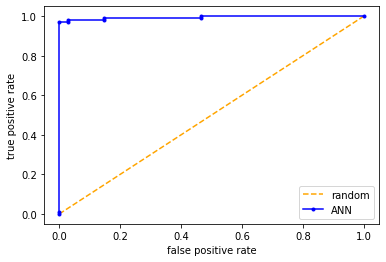

In [47]:
printAUROC(y,y_pred)

In [48]:
cf_matrix = confusion_matrix(y,(y_pred > 0.5))

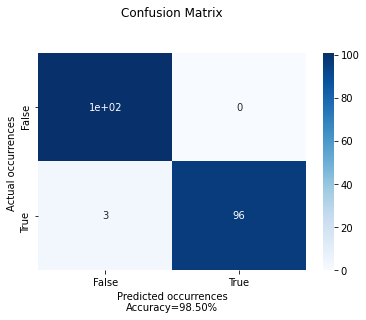

In [49]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('Predicted occurrences\nAccuracy={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Actual occurrences ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [50]:
output_dataset = None
output_dataset = dataset_original
output_dataset['score'] = y_pred

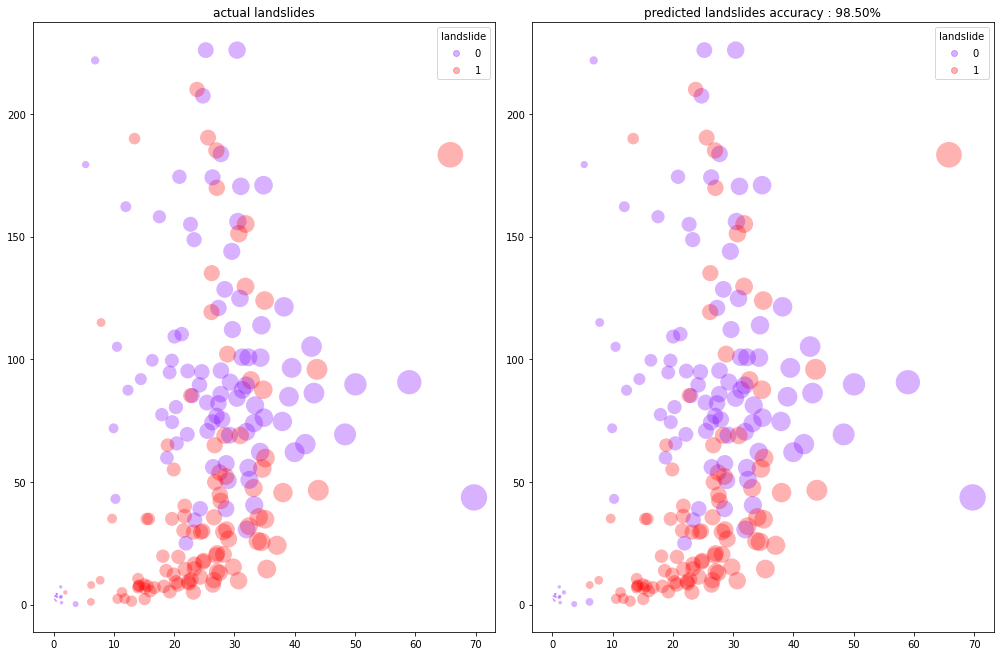

In [51]:
bubble_double_chart(output_dataset,"slope","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

#### RepeatedStratifiedKfold Assessment 

In [52]:
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


In [53]:
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Number of Splits_stratified of X: ',rskf.get_n_splits(X, y),'\n')

# Print_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

Number of Splits_stratified of X:  10 

(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)


In [54]:
print('List of obtained accuracies:', lst_accu_stratified)
print('\nMaximum accuracy:',
      max(lst_accu_stratified), '%')
print('\nMinimum accuracy:',
      min(lst_accu_stratified), '%')
print('\nAvarage accuracy:',
      statistics.mean(lst_accu_stratified), '%')
print('\nStandard deviation:', statistics.stdev(lst_accu_stratified))

List of obtained accuracies: [97.5, 100.0, 97.5, 100.0, 97.5, 100.0, 95.0, 100.0, 97.5, 100.0]

Maximum accuracy: 100.0 %

Minimum accuracy: 95.0 %

Avarage accuracy: 98.5 %

Standard deviation: 1.7480147469502525


In [55]:
dataset

,slope,aspect,elevation,land_use,lithology,twi,curvature,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0
...,...,...,...,...,...,...,...,...
195,65.807915,335.578705,183.386307,90,65,3.111852,0.009217,1
196,34.884327,335.742798,76.214539,90,2,34.884327,-0.003104,0
197,16.367725,167.967239,99.617256,90,2,16.367725,0.009234,0
198,30.434063,155.315613,226.055237,90,65,30.434063,0.000543,0


ROC AUC=0.993


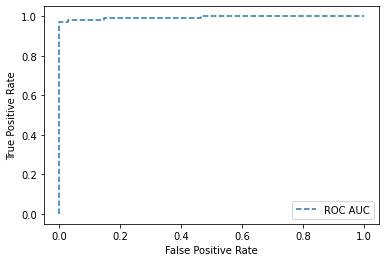

In [56]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [57]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_dataset = None
output_dataset = dataset_original
output_dataset['score'] = y_pred

Acurácia: 98.50%


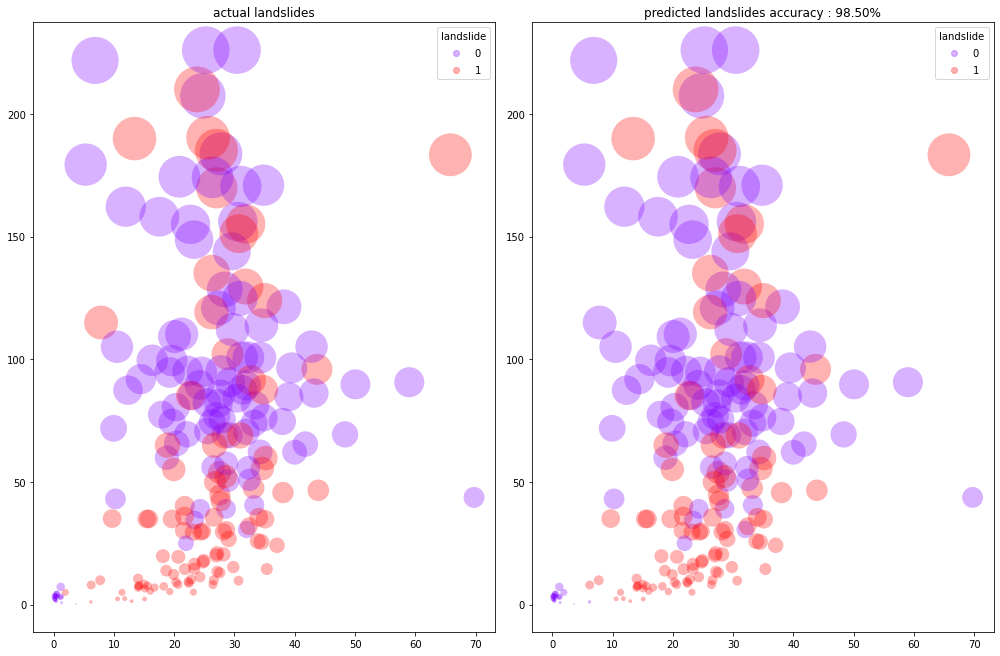

In [58]:
bubble_double_chart(output_dataset,"elevation","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

In [59]:
end = datetime.datetime.now()
print(end-start)
#quit()

0:50:21.568378


### Keras Framework
__Clasification problem, see best practices:__
- Hyperparameters tuning
- Baseline to custom implementation 

In [60]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [61]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(24, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(24, activation='relu'))
hypermodel.add(Dropout(0.43719886068153724))

hypermodel.add(Dense(1, activation='sigmoid'))
learning_rate= 0.01
myOptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
hypermodel.compile(optimizer=myOptimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [62]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/500
20/20 [==============================] - 1s 1ms/step - loss: 0.7226 - accuracy: 0.5000
Epoch 2/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6838 - accuracy: 0.5408
Epoch 3/500
20/20 [==============================] - 0s 1ms/step - loss: 0.7104 - accuracy: 0.5306
Epoch 4/500
20/20 [==============================] - 0s 1ms/step - loss: 0.7016 - accuracy: 0.5000
Epoch 5/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6732 - accuracy: 0.5714
Epoch 6/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6680 - accuracy: 0.5714
Epoch 7/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6534 - accuracy: 0.6224
Epoch 8/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6217 - accuracy: 0.7347
Epoch 9/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6384 - accuracy: 0.7041
Epoch 10/500
20/20 [==============================] - 0s 1ms/step - loss: 0.6440 - accuracy: 0.7041
Epoch 11/

Epoch 83/500
20/20 [==============================] - 0s 3ms/step - loss: 0.2029 - accuracy: 0.9388
Epoch 84/500
20/20 [==============================] - 0s 2ms/step - loss: 0.2031 - accuracy: 0.9184
Epoch 85/500
20/20 [==============================] - 0s 3ms/step - loss: 0.2084 - accuracy: 0.8980
Epoch 86/500
20/20 [==============================] - 0s 3ms/step - loss: 0.1992 - accuracy: 0.9388
Epoch 87/500
20/20 [==============================] - 0s 3ms/step - loss: 0.2242 - accuracy: 0.9388
Epoch 88/500
20/20 [==============================] - 0s 2ms/step - loss: 0.2422 - accuracy: 0.8980
Epoch 89/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1976 - accuracy: 0.9184
Epoch 90/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1778 - accuracy: 0.9490
Epoch 91/500
20/20 [==============================] - 0s 3ms/step - loss: 0.2111 - accuracy: 0.9388
Epoch 92/500
20/20 [==============================] - 0s 3ms/step - loss: 0.1522 - accuracy: 0.9694


20/20 [==============================] - 0s 2ms/step - loss: 0.0755 - accuracy: 0.9796
Epoch 165/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1150 - accuracy: 0.9286
Epoch 166/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0916 - accuracy: 0.9796
Epoch 167/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9796
Epoch 168/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0748 - accuracy: 0.9796
Epoch 169/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0912 - accuracy: 0.9592
Epoch 170/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0982 - accuracy: 0.9490
Epoch 171/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0715 - accuracy: 0.9898
Epoch 172/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1150 - accuracy: 0.9490
Epoch 173/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0836 - accuracy: 0.9694
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.9796
Epoch 246/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0936 - accuracy: 0.9694
Epoch 247/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0741 - accuracy: 0.9592
Epoch 248/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0978 - accuracy: 0.9592
Epoch 249/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0759 - accuracy: 0.9796
Epoch 250/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0686 - accuracy: 0.9796
Epoch 251/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0679 - accuracy: 0.9694
Epoch 252/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0690 - accuracy: 0.9796
Epoch 253/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0739 - accuracy: 0.9796
Epoch 254/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0480 - accuracy: 0.9796
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 0.0409 - accuracy: 0.9898
Epoch 327/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0451 - accuracy: 0.9796
Epoch 328/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0454 - accuracy: 1.0000
Epoch 329/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0574 - accuracy: 0.9898
Epoch 330/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0398 - accuracy: 1.0000
Epoch 331/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0588 - accuracy: 0.9694
Epoch 332/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0580 - accuracy: 0.9796
Epoch 333/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0453 - accuracy: 0.9898
Epoch 334/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.9694
Epoch 335/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0446 - accuracy: 0.9796
Epoc

20/20 [==============================] - 0s 1ms/step - loss: 0.0328 - accuracy: 0.9898
Epoch 408/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0553 - accuracy: 0.9898
Epoch 409/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0395 - accuracy: 0.9898
Epoch 410/500
20/20 [==============================] - 0s 5ms/step - loss: 0.0339 - accuracy: 0.9898
Epoch 411/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0439 - accuracy: 0.9898
Epoch 412/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0276 - accuracy: 1.0000
Epoch 413/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0521 - accuracy: 0.9796
Epoch 414/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0417 - accuracy: 0.9898
Epoch 415/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0497 - accuracy: 0.9796
Epoch 416/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0460 - accuracy: 0.9898
Epoc

20/20 [==============================] - 0s 1ms/step - loss: 0.0399 - accuracy: 0.9898
Epoch 489/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0377 - accuracy: 0.9898
Epoch 490/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0345 - accuracy: 1.0000
Epoch 491/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0538 - accuracy: 0.9694
Epoch 492/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0494 - accuracy: 0.9796
Epoch 493/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0326 - accuracy: 1.0000
Epoch 494/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0389 - accuracy: 0.9898
Epoch 495/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0275 - accuracy: 1.0000
Epoch 496/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0361 - accuracy: 1.0000
Epoch 497/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0240 - accuracy: 1.0000
Epoc

In [63]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 188


In [64]:
# keras assessment
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 3ms/step - loss: 0.1201 - accuracy: 0.9667
Accuracy: 96.67


In [65]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/188
4/4 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 1.0000
Epoch 2/188
4/4 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 1.0000
Epoch 3/188
4/4 [==============================] - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9898
Epoch 4/188
4/4 [==============================] - 0s 2ms/step - loss: 0.0272 - accuracy: 1.0000
Epoch 5/188
4/4 [==============================] - 0s 2ms/step - loss: 0.0285 - accuracy: 1.0000
Epoch 6/188
4/4 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9796
Epoch 7/188
4/4 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 1.0000
Epoch 8/188
4/4 [==============================] - 0s 2ms/step - loss: 0.0327 - accuracy: 0.9898
Epoch 9/188
4/4 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 1.0000
Epoch 10/188
4/4 [==============================] - 0s 3ms/step - loss: 0.0272 - accuracy: 1.0000
Epoch 11/188
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 0.0325 - accuracy: 0.9898
Epoch 85/188
4/4 [==============================] - 0s 4ms/step - loss: 0.0394 - accuracy: 0.9796
Epoch 86/188
4/4 [==============================] - 0s 5ms/step - loss: 0.0373 - accuracy: 0.9898
Epoch 87/188
4/4 [==============================] - 0s 4ms/step - loss: 0.0258 - accuracy: 1.0000
Epoch 88/188
4/4 [==============================] - 0s 5ms/step - loss: 0.0279 - accuracy: 1.0000
Epoch 89/188
4/4 [==============================] - 0s 4ms/step - loss: 0.0276 - accuracy: 0.9898
Epoch 90/188
4/4 [==============================] - 0s 4ms/step - loss: 0.0346 - accuracy: 0.9796
Epoch 91/188
4/4 [==============================] - 0s 4ms/step - loss: 0.0174 - accuracy: 1.0000
Epoch 92/188
4/4 [==============================] - 0s 3ms/step - loss: 0.0266 - accuracy: 1.0000
Epoch 93/188
4/4 [==============================] - 0s 4ms/step - loss: 0.0196 - accuracy: 1.0000
Epoch 94/188
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.0349 - accuracy: 0.9898
Epoch 168/188
4/4 [==============================] - 0s 4ms/step - loss: 0.0209 - accuracy: 1.0000
Epoch 169/188
4/4 [==============================] - 0s 4ms/step - loss: 0.0258 - accuracy: 1.0000
Epoch 170/188
4/4 [==============================] - 0s 3ms/step - loss: 0.0257 - accuracy: 0.9898
Epoch 171/188
4/4 [==============================] - 0s 3ms/step - loss: 0.0335 - accuracy: 1.0000
Epoch 172/188
4/4 [==============================] - 0s 5ms/step - loss: 0.0225 - accuracy: 0.9898
Epoch 173/188
4/4 [==============================] - 0s 4ms/step - loss: 0.0200 - accuracy: 1.0000
Epoch 174/188
4/4 [==============================] - 0s 3ms/step - loss: 0.0174 - accuracy: 1.0000
Epoch 175/188
4/4 [==============================] - 0s 3ms/step - loss: 0.0195 - accuracy: 1.0000
Epoch 176/188
4/4 [==============================] - 0s 3ms/step - loss: 0.0297 - accuracy: 0.9898
Epoch 177/188
4/4 [=====

#### Assessment

In [66]:
# Keras assessment
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 3ms/step - loss: 0.1233 - accuracy: 0.9667
Accuracy: 96.67


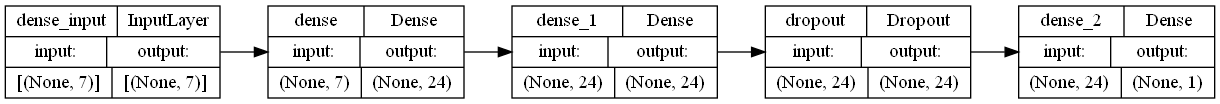

In [67]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved if its accuracy with test sample surpass 85%.

In [68]:
accu = 100*accuracy

In [69]:
if accu >= 85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved in \033[1m{}\033[0m!'.format(accu,NN_keras))
    hypermodel.save(NN_keras) 
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

96.67%, excellent accuracy for test sample, ANN saved in bestANN\kerasNN_guaruja_random!
INFO:tensorflow:Assets written to: bestANN\kerasNN_guaruja_random\assets


#### RepeatedStratifiedKFold Assessment

In [70]:
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Splits numbers of X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

Splits numbers of X:  10 

2/2 [==============================] - 0s 2ms/step


In [71]:
print('List of obtained accuracies:', lst_accu_stratified)
print('\nMaximum accuracy:',
      max(lst_accu_stratified), '%')
print('\nMinimum accuracy:',
      min(lst_accu_stratified), '%')
print('\nAvarage accuracy:',
      statistics.mean(lst_accu_stratified), '%')
print('\nStandard deviation:', statistics.stdev(lst_accu_stratified))

List of obtained accuracies: [100.0, 100.0, 95.0, 100.0, 100.0, 100.0, 97.5, 97.5, 100.0, 100.0]

Maximum accuracy: 100.0 %

Minimum accuracy: 95.0 %

Avarage accuracy: 99.0 %

Standard deviation: 1.7480147469502525


In [72]:
y_pred = hypermodel.predict(X_test)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

2/2 [==============================] - 0s 2ms/step
Accuracy: 96.67%


In [73]:
y_pred = hypermodel.predict(X_train)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

4/4 [==============================] - 0s 2ms/step
Accuracy: 100.00%


In [74]:
y_pred = hypermodel.predict(X_val)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

2/2 [==============================] - 0s 2ms/step
Accuracy: 100.00%


In [75]:
y_pred = hypermodel.predict(X)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

7/7 [==============================] - 0s 2ms/step
Accuracy: 99.00%


In [76]:
NetworkPerformance(y, y_pred)

Accuracy: 0.990000
Precision: 0.989899
Recall: 0.989899
F1 score: 0.989899
Cohens kappa: 0.979998
ROC AUC: 0.997200
[[100   1]
 [  1  98]]


ROC AUC=0.997


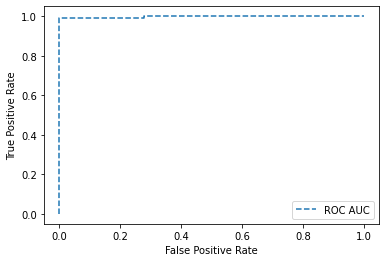

In [77]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

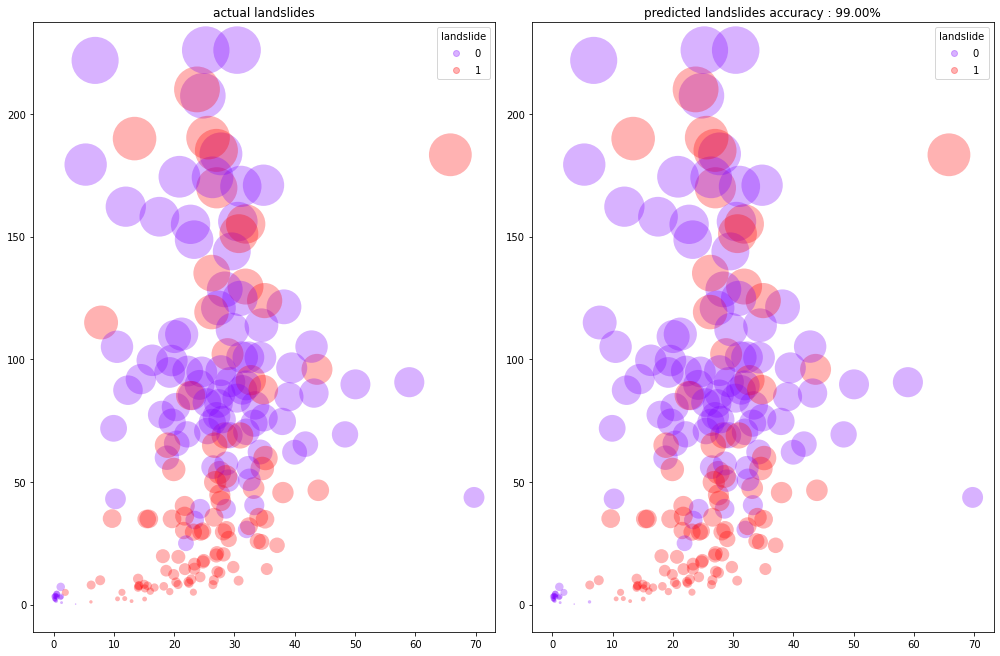

In [78]:
bubble_double_chart(output_dataset,"elevation","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

In [79]:
end = datetime.datetime.now()
print(end-start)

0:50:52.951439


## References
- ref.1: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref.2: https://www.tensorflow.org/tutorials/structured_data/feature_columns
- ref.3: https://realpython.com/train-test-split-python-data/
- ref.4: https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref.5: https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref.6: https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref.7: https://www.section.io/engineering-education/data-leakage/
- ref.8: https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1
- ref.9: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
- ref. 10: https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb
- ref. 11: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
- ref. 12: http://karpathy.github.io/2019/04/25/recipe/
- ref. 13: https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
- ref. 14: https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/
- ref. 15: https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece
- ref. 16: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. 17: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
- ref. 18: https://machinelearningmastery.com/data-preparation-without-data-leakage/